<a href="https://colab.research.google.com/github/realalyeasin/Machine-Learning/blob/main/%F0%9F%94%A0Basic_Text_Classification_%E2%9A%99%EF%B8%8F_%7C%7C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import os
import re
import string
import shutil
import tensorflow as tf

from tensorflow.keras import losses, layers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.5.0


In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",
                                  origin = url,
                                  untar = True,
                                  cache_subdir='',
                                  cache_dir = ".")
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 5s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'README', 'test', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'urls_unsup.txt',
 'pos']

In [14]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [15]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [17]:
len(os.listdir(train_dir))

7

In [18]:
batch_size = 30
seed = 40

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                  batch_size = batch_size,
                                                                  seed = seed,
                                                                  validation_split = 0.2,
                                                                  shuffle = True,
                                                                  subset = 'training')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [19]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review : ", text_batch.numpy()[i])
    print("Label : ", label_batch.numpy()[i])

Review :  b"This picture came out in 1975 and it was the second in the three part series of the life of Sheriff Buford Pusser. Bo Svenson takes over the role of Sheriff Buford Pusser, and Luke Askew plays the role of Mobster Pinky Dobson. The last that we saw Sheriff Pusser he was laying in a hospital bed after him and his wife who was killed in ambushed Sunday morning drive. After Pusser recovers he goes after the men that killed his wife. Is Pusser able to complete the revenge that he's after or does the mob try to take him out before he successes. The only thing that bother me about this picture that this was an actual true story. How could you leave in a town with this kind of crime and yet don't do anything about it. Since there was real no name actress in this picture I can't give it 10 weasel stars but I can give 8"
Label :  1
Review :  b'I saw the movie with two grown children. Although it was not as clever as Shrek, I thought it was rather good. In a movie theatre surrounded b

In [22]:
print("Label 0 :", raw_train_ds.class_names[0])
print("Label 1 :", raw_train_ds.class_names[1])

Label 0 : neg
Label 1 : pos


In [23]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                batch_size = batch_size,
                                                                seed = seed,
                                                                validation_split = 0.2,
                                                                subset = 'validation',
                                                                shuffle = True)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [24]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                 batch_size = batch_size)

Found 25000 files belonging to 2 classes.


In [25]:
def custom_standardization(input_data):
  lower_case = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lower_case, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),'')

In [26]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize = custom_standardization,
                                    max_tokens = max_features,
                                    output_mode = 'int',
                                    output_sequence_length = sequence_length)

In [27]:
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text)

In [28]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [32]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("First Review : ", first_review)
print("First Label : ", raw_train_ds.class_names[first_label])
print("Vectorized Review : ", vectorize_text(first_review, first_label))

First Review :  tf.Tensor(b"A year after losing gorgeous Jane Parker (Maureen O'Sullivan) to love rival Tarzan, hunter Harry Holt (Neil Hamilton) returns to the jungle to have another bash at winning the brunette babe's heart. Mixing business with pleasure, he also plans to grab himself some ivory from the elephant graveyard that lies beyond the Mutia escarpment, Tarzan's stomping ground.<br /><br />Accompanied by his slimy, womanising pal Martin Arlington and a group of expendable bearers, Harry finally arrives at his destination (having narrowly avoided death at the hands of savage natives and rock-hurling apes) only to find that Jane is still infatuated with her musclebound yodeller, and worse still, that Tarzan is refusing to let the hunters take any ivory from the graveyard.<br /><br />Nasty Arlington decides to resolve matters by ambushing and shooting the ape-man and then telling Jane and Holt that Tarzan was attacked and eaten by a crocodile. Of course, Tarzan isn't dead\xc2\x9

In [33]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
embedding_dim = 16

In [38]:
model = tf.keras.Sequential([
                             layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs =10
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/10
667/667 [==============================] - 13s 18ms/step - loss: 0.6614 - accuracy: 0.5077 - val_loss: 0.6060 - val_accuracy: 0.5754
Epoch 2/10
667/667 [==============================] - 5s 7ms/step - loss: 0.5392 - accuracy: 0.6772 - val_loss: 0.4839 - val_accuracy: 0.7744
Epoch 3/10
667/667 [==============================] - 5s 7ms/step - loss: 0.4350 - accuracy: 0.8009 - val_loss: 0.4073 - val_accuracy: 0.8246
Epoch 4/10
667/667 [==============================] - 5s 7ms/step - loss: 0.3693 - accuracy: 0.8461 - val_loss: 0.3634 - val_accuracy: 0.8478
Epoch 5/10
667/667 [==============================] - 5s 7ms/step - loss: 0.3276 - accuracy: 0.8650 - val_loss: 0.3366 - val_accuracy: 0.8586
Epoch 6/10
667/667 [==============================] - 5s 7ms/step - loss: 0.2981 - accuracy: 0.8794 - val_loss: 0.3189 - val_accuracy: 0.8668
Epoch 7/10
667/667 [==============================] - 5s 7ms/step - loss: 0.2748 - accuracy: 0.8897 - val_loss: 0.3068 - val_accuracy: 0.8728
Epoc

In [41]:
loss, accuracy = model.evaluate(test_ds)
print("Loss :", loss)
print("Accuracy :", accuracy) 

834/834 [==============================] - 11s 13ms/step - loss: 0.3107 - accuracy: 0.8646
Loss : 0.31066474318504333
Accuracy : 0.8646000027656555


In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

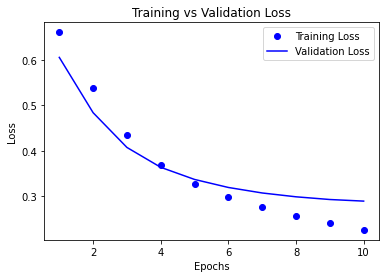

In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

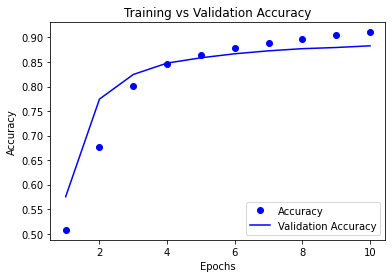

In [46]:
plt.plot(epochs, acc, 'bo', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()